In [1]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
import dpmm
%matplotlib inline

In [2]:
# Make a 1-D Gaussian mixture model with all component means = 0 and specified variances.
class gaussV(object):
    def __init__(self, V):
        self.V = V

    def sample(self, size=None):
        return np.random.normal(scale=np.sqrt(self.V), size=size)

    def __call__(self, x):
        return np.exp(-0.5*x**2/self.V)/np.sqrt(2*np.pi*self.V)

class MM(object):
    def __init__(self, components, proportions):
        self.components = components
        self.proportions = proportions

    def sample(self, size=None):
        if size is None:
            nums = np.random.multinomial(1, self.proportions)
            c = num.index(1) # which class got picked
            return self.components[c].sample()
        else:
            out = np.empty((size,), dtype=float)
            nums = np.random.multinomial(size, self.proportions)
            i = 0
            for component, num in zip(self.components, nums):
                out[i:i+num] = component.sample(size=num)
                i += num
            return out

    def __call__(self, x):
        return np.sum([p*c(x) for p, c in zip(self.proportions, self.components)], axis=0)

    def plot(self, axis=None, **kwargs):
        """ Plot the mixture model pdf."""
        if axis is None:
            axis = plt.gca()
        x = np.arange(-2,2,0.01)
        y = self(x)
        axis.plot(x, y, **kwargs)

In [3]:
# Mixture model parameters
V = [0.3**2, 0.05**2]  # variances
p = [0.5, 0.5]   # proportions
model = MM([gaussV(V0) for V0 in V], p)

/Users/josh/miniconda2/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


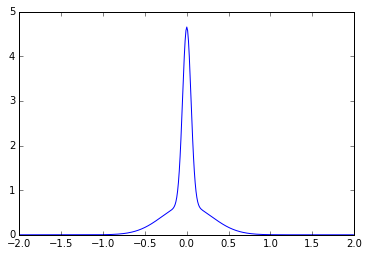

In [4]:
# Plot the generative distribution
f = plt.figure(figsize=(6,4))
ax = f.add_subplot(111)
model.plot(axis=ax)
f.show()

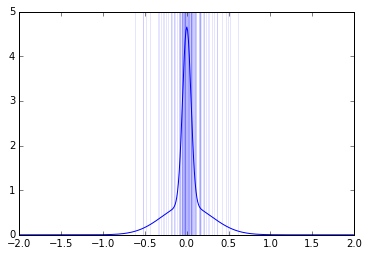

In [5]:
# Draw some samples with which to do inference.
data = model.sample(size=100)
# Plot with samples
f = plt.figure(figsize=(6, 4))
ax = f.add_subplot(111)
model.plot(axis=ax)
for x in data:
    ax.axvline(x, alpha=0.1)
f.show()

In [39]:
# Create the Dirichlet Process Mixture Model.
# Use the Inverse Gamma prior for a Gaussian with known mean and unknown variance.
mu = 0.0  # Known mean
alpha = 1.0   # How well we know beta
beta = 100.0  # 1/typical-variance
dp_alpha = 0.1 # Dirichlet Process clustering parameter.  Set lower to infer fewer components.
cp = dpmm.InvGamma(alpha, beta, mu)
dp = dpmm.DPMM(cp, dp_alpha, data)

In [40]:
# Burn in
dp.update(100)

In [41]:
phis = []
nphis = []
# Sample
for i in xrange(50):
    dp.update(10)
    phis.append(list(dp.phi)) # Need list() to get a copy
    nphis.append(list(dp.nphi))

In [42]:
def plot_sample(phi, nphi, axis=None, **kwargs):
    x = np.arange(-1, 1, 0.01)
    y = np.zeros_like(x)
    for ph, n in zip(phi, nphi):
        y += n*np.exp(-0.5*x**2/ph)/np.sqrt(2*np.pi*ph)/sum(nphi)
    if axis is None:
        axis = plt.gca()
    axis.plot(x, y, **kwargs)

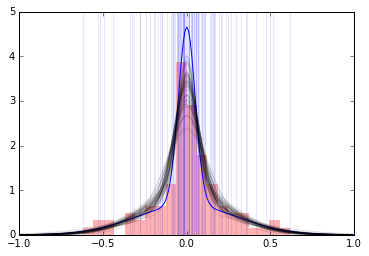

In [43]:
# Plot with samples
f = plt.figure(figsize=(6, 4))
ax = f.add_subplot(111)
model.plot(axis=ax)
for x in data:
    ax.axvline(x, alpha=0.1)
for phi, nphi in zip(phis, nphis):
    plot_sample(phi, nphi, axis=ax, alpha=0.1, c='k')
ax.set_xlim(-1,1)
ax.hist(data, 20, alpha=0.3, color='r', normed=True)
f.show()

In [52]:
# Try a large-ish data set.
# For WL, we can concatenate the e1 and e2 samples together after deshearing.  Then we have 20000 e samples per
# GREAT3 field.
data = model.sample(size=20000)
mu = 0.0
alpha = 1.0
beta = 100.0
dp_alpha = 0.1
cp = dpmm.InvGamma(alpha, beta, mu)
dp = dpmm.DPMM(cp, dp_alpha, data)

In [53]:
prun dp.update(100) # about 35 sec

In [54]:
# a few minutes to generate 500 samples and store every 10th one (i.e., store 50).
phis = []
nphis = []
# Sample
for i in xrange(50):
    dp.update(10)
    phis.append(list(dp.phi)) # Need list() to get a copy
    nphis.append(list(dp.nphi))

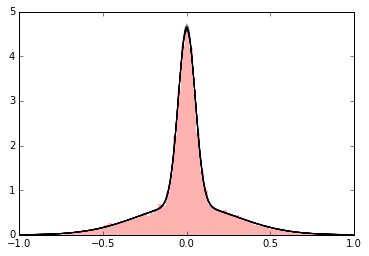

In [55]:
# Plot with samples
f = plt.figure(figsize=(6, 4))
ax = f.add_subplot(111)
model.plot(axis=ax)
# for x in data:
#     ax.axvline(x, alpha=0.002)
for phi, nphi in zip(phis, nphis):
    plot_sample(phi, nphi, axis=ax, alpha=0.1, c='k')
ax.set_xlim(-1, 1)
ax.hist(data, 100, alpha=0.3, color='r', normed=True)
f.show()

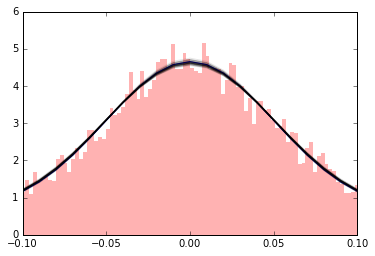

In [56]:
# Zoom in
f = plt.figure(figsize=(6, 4))
ax = f.add_subplot(111)
model.plot(axis=ax)
# for x in data:
#     ax.axvline(x, alpha=0.002)
for phi, nphi in zip(phis, nphis):
    plot_sample(phi, nphi, axis=ax, alpha=0.1, c='k')
ax.set_xlim(-0.1, 0.1)
ax.hist(data, 1000, alpha=0.3, color='r', normed=True)
f.show()

In [57]:
nphis

[[9818, 10182],
 [9929, 10069, 2],
 [9938, 10062],
 [9834, 10166],
 [9880, 10119, 1],
 [9839, 10122, 39],
 [9893, 10087, 20],
 [9839, 10137, 18, 6],
 [9946, 10018, 36],
 [9943, 9975, 82],
 [9842, 9942, 216],
 [9771, 9855, 374],
 [9966, 9805, 229],
 [9739, 10083, 178],
 [9863, 10015, 122],
 [9870, 10006, 106, 18],
 [9954, 9924, 82, 35, 5],
 [9993, 9900, 62, 33, 12],
 [9776, 10006, 53, 18, 63, 84],
 [9865, 10009, 1, 54, 71],
 [9773, 9988, 81, 158],
 [9936, 9882, 29, 153],
 [9842, 10060, 2, 96],
 [9944, 10037, 19],
 [9895, 10093, 12],
 [9838, 10162],
 [9798, 10202],
 [9857, 10137, 6],
 [9857, 10143],
 [10015, 9985],
 [9999, 10001],
 [9832, 10168],
 [9932, 10068],
 [10013, 9985, 2],
 [9911, 10087, 2],
 [9918, 10073, 9],
 [9893, 10107],
 [9989, 10011],
 [9926, 10074],
 [9907, 10093],
 [9968, 10029, 3],
 [9872, 10128],
 [9927, 10070, 3],
 [9905, 10081, 14],
 [9951, 10044, 5],
 [9902, 10098],
 [9870, 10130],
 [10000, 9994, 5, 1],
 [9994, 10005, 1],
 [10000, 9999, 1]]